# Generating 1-bit potentials using error diffusion

[Generating patterns using Error Diffusion - Useful article](https://arxiv.org/pdf/2202.04986)

## Pattern Generation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from PIL import Image
import os
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [2]:
# Defne the error diffusion parameters (direction and weight)

error_diffusion_set = [
    (0,-1,7/16),
    (-1,0,5/16),
    (-1,1,3/16),
    (-1,-1,1/16)]

In [15]:
# Define the size of the window to display on the DMD

# Dimensions of the DMD
N = 1080
M = 1920

# Padding
# N_min = 140 # 0 is top
# N_max = 820
# M_min = 1000  # 0 is left
# M_max = 1750

# N_min = 200
# N_max = 1010
# M_min = 570
# M_max = 1330

# Npx = N_max - N_min
# Mpx = M_max - M_min
# print(Npx, Mpx)


cicero_analog = np.array(Image.open('/Users/gabseig/Documents/MIT/Cicero_BW.jpg').convert('L'))/255

N_max = cicero_analog.shape[0]
M_max = cicero_analog.shape[1]

N_min = 0
M_min = 0

Npx = N_max - N_min
Mpx = M_max - M_min
print(Npx, Mpx)

500 389


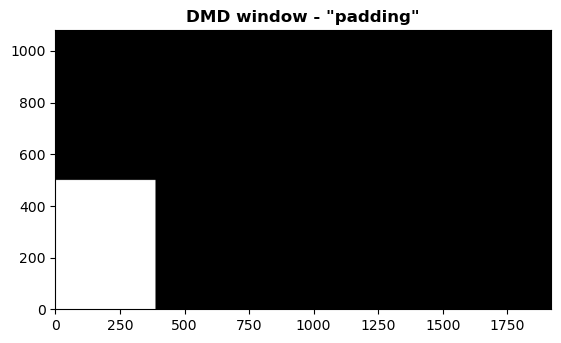

In [7]:
# plot the padding
plt.figure()

f = np.zeros((N,M))
f[N_min:N_max,M_min:M_max] = 1
plt.imshow(f, cmap='gray')
plt.title('DMD window - "padding"', fontweight='bold')
plt.ylim([0,N])
plt.show()




In [8]:
# Implement the error diffusion algorithm

def perform_error_diffusion(ref_image_analog,error_diffusion_set):
    q = np.round(ref_image_analog, 0) # Initialise the 1-bit image
    v = np.zeros_like(ref_image_analog) # store the error values during the diffusion process
    
    for i in range(Npx): # iterating through y axis

        for j in range(Mpx): # iteration through x axis
            v_sum = 0

            for di,dj,w in error_diffusion_set:
                ni = i+di # computing the coordinates of the neighbors in the direction (di, dj)
                nj = j+dj
                if ni>0 and nj<Mpx: # valid bounds
                    v_sum += v[ni,nj]*w # add error from the neighbors, weighted by the weight in error_diffusion_set

            q[i,j] = np.round(v_sum+ref_image_analog[i,j], 0)
            v[i,j] = v_sum+ ref_image_analog[i,j] - q[i,j]

    # Return the 1-bit error-diffused image
    return q

0.8274509803921568
1.0


Text(0.5, 1.0, 'Cicero ED image')

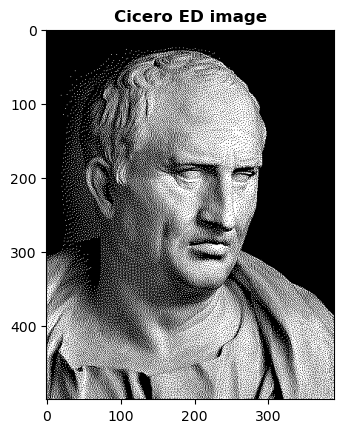

In [21]:
cicero_ED = perform_error_diffusion(cicero_analog,error_diffusion_set)
print(cicero_analog[200,200])
print(cicero_ED[200,200])

# Save cicero ED image
cicero_ED = (cicero_ED * 255).astype(np.uint8)  # Convert to uint8 for display
Image.fromarray(cicero_ED).save('/Users/gabseig/Documents/MIT/Cicero_ED.png')
plt.imshow(cicero_ED, cmap='gray')
plt.title('Cicero ED image', fontweight='bold')

In [8]:
# Generating reference images (values need to be between 0 and 1, so scaling is important)

def normalised_Gaussian(N, M, sigma):
    x = np.linspace(-4*sigma, 4*sigma, M)
    y = np.linspace(-4*sigma, 4*sigma, N)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(-((X**2 + Y**2) / (2.0 * sigma**2)))
    return Z

def atom_Gaussian(N, M, sigma_atom):
    # Generates a grid of Gaussian potentials representing atoms, with 10 px per lattice site
    x = np.linspace(0, M, M)
    y = np.linspace(0, N, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((N,M))

    # Set the step
    step_x = 10
    step_y = 10

    for i in range(step_y, N, step_y):
        for j in range(step_x, M, step_x):
            Z += np.exp(-((X-j)**2 + (Y-i)**2) / (2.0 * sigma_atom**2))
    return Z

def sphere_potential(N, M, sigma_sphere):
    # Generates a sphere potential projected onto an N x M pixel grid
    x = np.linspace(0, M, M)
    y = np.linspace(0, N, N)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(-((X-M//2)**2 + (Y-N//2)**2) / (2.0 * sigma_sphere**2))
    return Z

def gradient(N, M):
    x = np.linspace(0, M, M)
    y = np.linspace(0, N, N)
    X, Y = np.meshgrid(x, y)
    Z = (X + Y) / (N + M)
    return Z

In [9]:
# Tests
Gaussian_DMD = normalised_Gaussian(Npx, Mpx, 100)
atom_Gaussian_DMD = atom_Gaussian(Npx, Mpx, 1.5)
Sphere_DMD = sphere_potential(Npx, Mpx, 100)
Gradient_DMD = gradient(Npx, Mpx)


# Compute the eror-diffused image
Gaussian_DMD_ED = perform_error_diffusion(Gaussian_DMD, error_diffusion_set)
atom_Gaussian_DMD_ED = perform_error_diffusion(atom_Gaussian_DMD, error_diffusion_set)
Sphere_DMD_ED = perform_error_diffusion(Sphere_DMD, error_diffusion_set)
Gradient_DMD_ED = perform_error_diffusion(Gradient_DMD, error_diffusion_set)

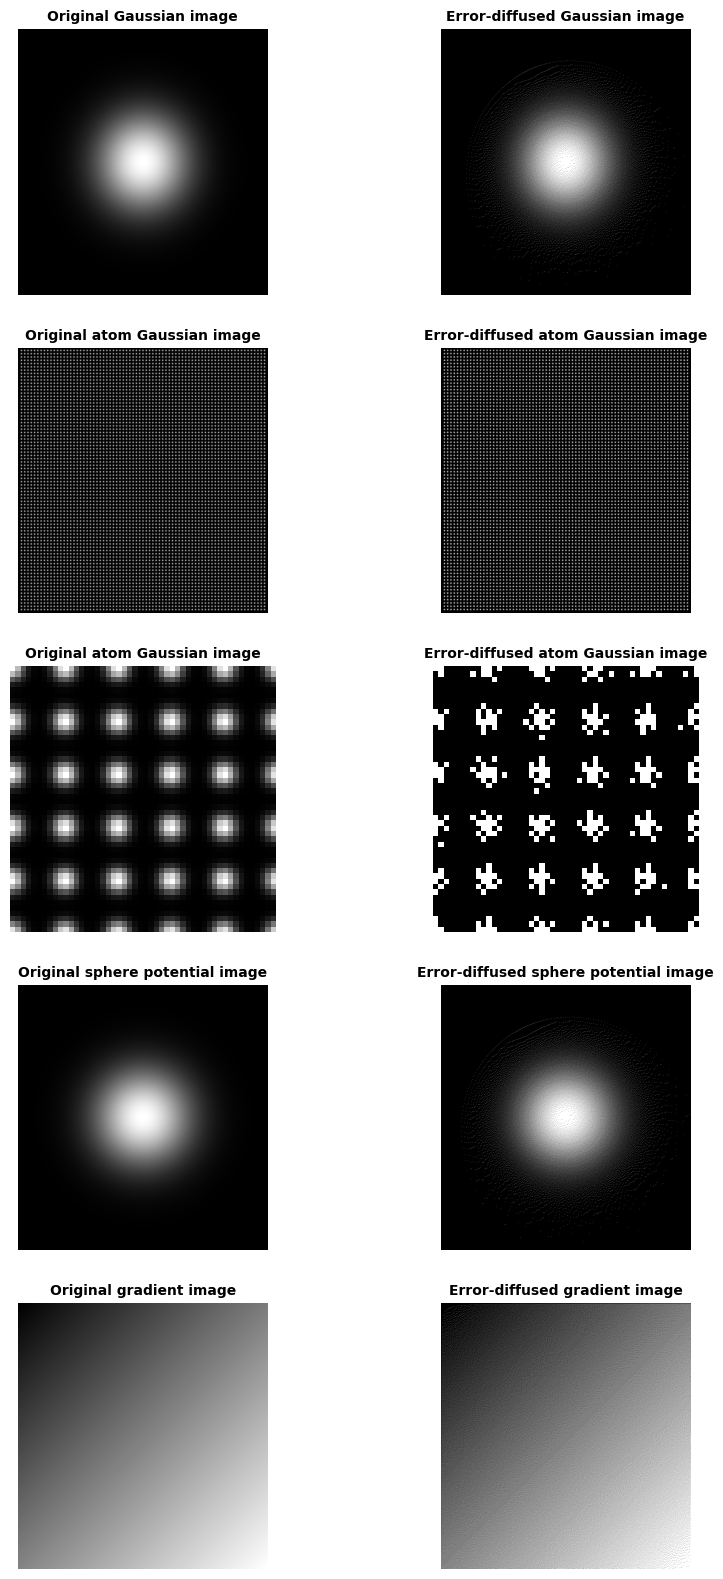

In [10]:
# Print the original, the error-diffused images and the residuals
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

# Original Gaussian image
ax[0, 0].imshow(Gaussian_DMD, cmap='gray')
ax[0, 0].set_title('Original Gaussian image', fontsize=10, fontweight='bold')
ax[0, 0].axis('off')

# Error-diffused Gaussian image
ax[0, 1].imshow(Gaussian_DMD_ED, cmap='gray')
ax[0, 1].set_title('Error-diffused Gaussian image', fontsize=10, fontweight='bold')
ax[0, 1].axis('off')

# Original atom Gaussian image
ax[1, 0].imshow(atom_Gaussian_DMD, cmap='gray')
ax[1, 0].set_title('Original atom Gaussian image', fontsize=10, fontweight='bold')
ax[1, 0].axis('off')

# Error-diffused atom Gaussian image
ax[1, 1].imshow(atom_Gaussian_DMD_ED, cmap='gray')
ax[1, 1].set_title('Error-diffused atom Gaussian image', fontsize=10, fontweight='bold')
ax[1, 1].axis('off')

# Close-up on the atom Gaussian image
ax[2, 0].imshow(atom_Gaussian_DMD[150:200, 150:200], cmap='gray')
ax[2, 0].set_title('Original atom Gaussian image', fontsize=10, fontweight='bold')
ax[2, 0].axis('off')

# Close-up on the error-diffused atom Gaussian image
ax[2, 1].imshow(atom_Gaussian_DMD_ED[150:200, 150:200], cmap='gray')
ax[2, 1].set_title('Error-diffused atom Gaussian image', fontsize=10, fontweight='bold')
ax[2, 1].axis('off')

# Original sphere potential image
ax[3, 0].imshow(Sphere_DMD, cmap='gray')
ax[3, 0].set_title('Original sphere potential image', fontsize=10, fontweight='bold')
ax[3, 0].axis('off')

# Error-diffused sphere potential image
ax[3, 1].imshow(Sphere_DMD_ED, cmap='gray')
ax[3, 1].set_title('Error-diffused sphere potential image', fontsize=10, fontweight='bold')
ax[3, 1].axis('off')

# Original gradient image
ax[4, 0].imshow(Gradient_DMD, cmap='gray')
ax[4, 0].set_title('Original gradient image', fontsize=10, fontweight='bold')
ax[4, 0].axis('off')

# Error-diffused gradient image
ax[4, 1].imshow(Gradient_DMD_ED, cmap='gray')
ax[4, 1].set_title('Error-diffused gradient image', fontsize=10, fontweight='bold')
ax[4, 1].axis('off')

plt.show()

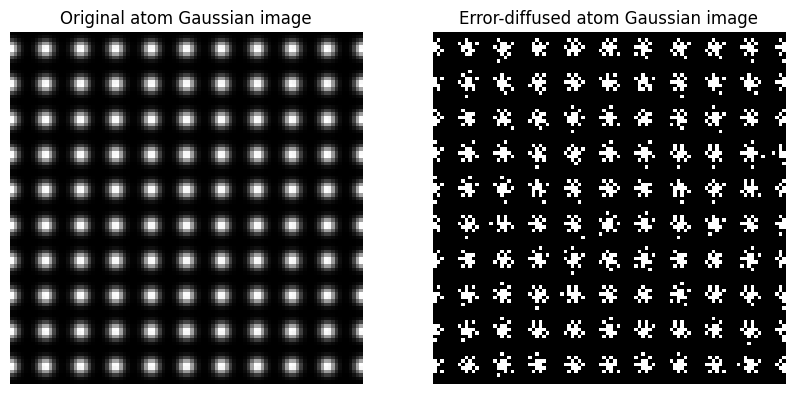

In [10]:
# Close-up on the atom Gaussian image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(atom_Gaussian_DMD[Npx//2-50:Npx//2+50, Mpx//2-50:Mpx//2+50], cmap='gray')
ax[0].set_title('Original atom Gaussian image')
ax[0].axis('off')

ax[1].imshow(atom_Gaussian_DMD_ED[Npx//2-50:Npx//2+50, Mpx//2-50:Mpx//2+50], cmap='gray')
ax[1].set_title('Error-diffused atom Gaussian image')
ax[1].axis('off')

plt.show()

In [11]:
## Embed the potentials in the padding

# Padding definition
f = np.zeros((N, M), dtype=np.uint8)
f[N_min:N_max, M_min:M_max] = 1

# Create the image to display on the DMD, with the potential in the non-zero region
image_Gaussian = np.zeros((N, M))
image_Gaussian[N_min:N_max, M_min:M_max] = Gaussian_DMD_ED

image_atom_Gaussian = np.zeros((N, M))
image_atom_Gaussian[N_min:N_max, M_min:M_max] = atom_Gaussian_DMD_ED

image_Sphere = np.zeros((N, M))
image_Sphere[N_min:N_max, M_min:M_max] = Sphere_DMD_ED

image_Gradient = np.zeros((N, M))
image_Gradient[N_min:N_max, M_min:M_max] = Gradient_DMD_ED


# Save to PNG files
Image.fromarray((image_Gaussian*255).astype(np.uint8)).save('./ED_Potentials/Gaussian.png')
Image.fromarray((image_atom_Gaussian*255).astype(np.uint8)).save('./ED_Potentials/atom_Gaussian.png')
Image.fromarray((image_Sphere*255).astype(np.uint8)).save('./ED_Potentials/Sphere.png')
Image.fromarray((image_Gradient*255).astype(np.uint8)).save('./ED_Potentials/Gradient.png')

(-0.5, 1919.5, 1079.5, -0.5)

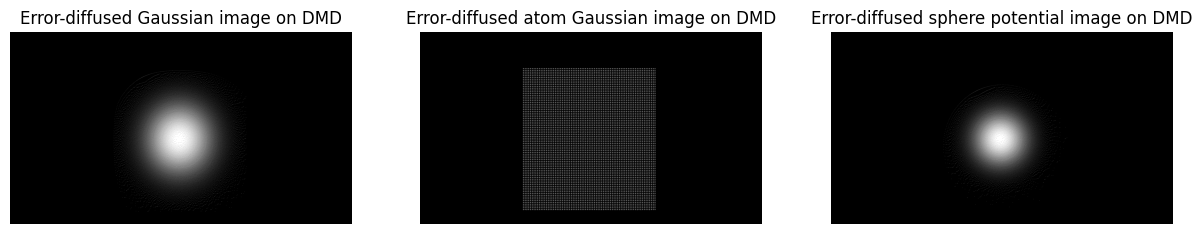

In [12]:
# Plot those
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image_Gaussian, cmap='gray')
ax[0].set_title('Error-diffused Gaussian image on DMD')
ax[0].axis('off')

ax[1].imshow(image_atom_Gaussian, cmap='gray')
ax[1].set_title('Error-diffused atom Gaussian image on DMD')
ax[1].axis('off')

ax[2].imshow(image_Sphere, cmap='gray')
ax[2].set_title('Error-diffused sphere potential image on DMD')
ax[2].axis('off')


## Data analysis

In [13]:
Ncam = 3000
Mcam = 4000

In [745]:
ROI_cam = (1100, 1900, 1700, 2430)

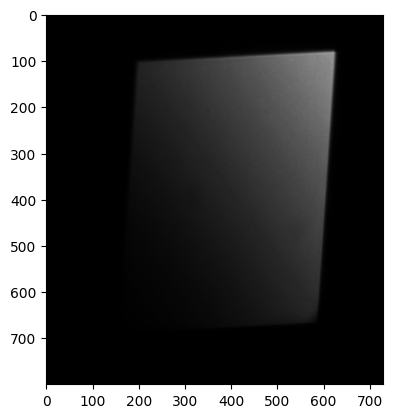

In [746]:
# Test
img_test = Image.open('./ED_Potentials_Images/3.png')
img_test = np.array(img_test)
plt.imshow(img_test[ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]])

In [747]:
# Retrieve the list of files in ./ED_Potentials_Images/
list_files = os.listdir('./ED_Potentials_Images')
list_files = [f for f in list_files if f.endswith('.png')]

In [748]:
# Rename all files
for file in list_files:
        new_name = file.split(sep='-')[-1]
        os.rename(f'./ED_Potentials_Images/{file}', f'./ED_Potentials_Images/{new_name}')

In [749]:
## HARDCODED
groups_ED_Images = {'Gradient': (0, 5), 'Sphere': (5, 15), 'Atom': (15, 25),  'Gaussian': (25, 35)}
average_number_frames_per_group = 10

In [750]:
# Average images together
averaged_frames = {}
for key in groups_ED_Images.keys():
    start, end = groups_ED_Images[key]
    averaged_frame = np.zeros((Ncam, Mcam), dtype=np.float32)
    for i in range(start, end):

        # Load image
        img = Image.open(f'./ED_Potentials_Images/{i}.png')
        im_array = np.array(img)

        # Take the Red channel if colour-processed
        if len(im_array.shape) > 2:
            img = np.array(img)[:,:,0]
        
        # Add frame to the averaged frame
        averaged_frame += img

    averaged_frame = averaged_frame / (end-start)

    # Store the averaged frame
    averaged_frames[key] = averaged_frame

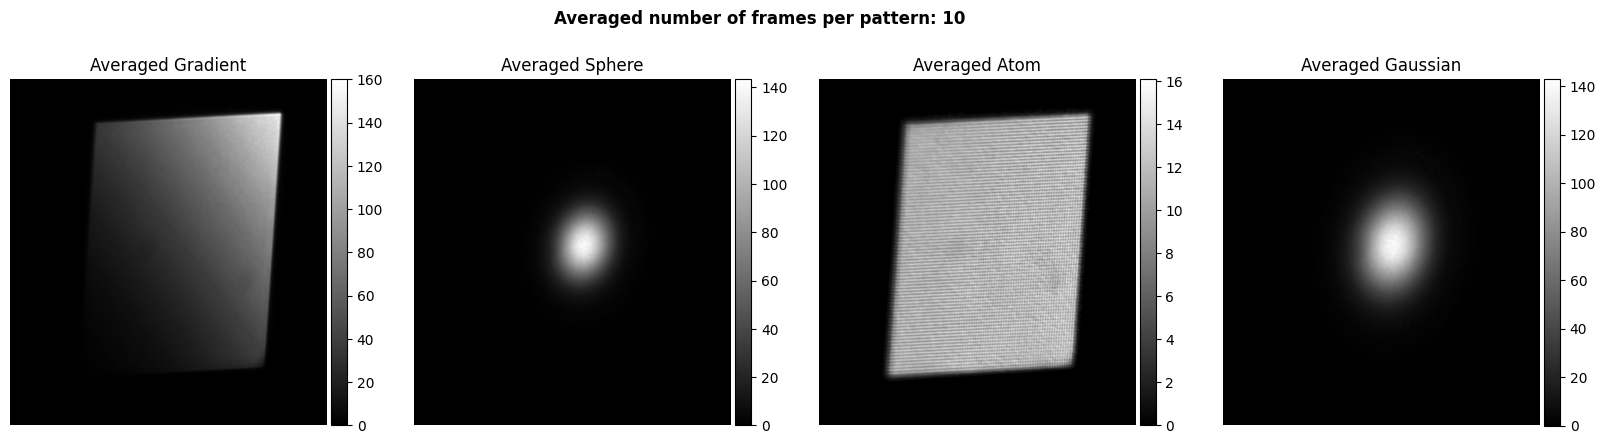

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot averaged frames, cropped to ROI_cam
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, key in enumerate(['Gradient', 'Sphere', 'Atom', 'Gaussian']):
    ax[i].imshow(averaged_frames[key][ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]], cmap='gray')
    ax[i].set_title(f'Averaged {key}')
    ax[i].axis('off')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(ax[i].images[0], cax=cax)

fig.suptitle(f'Averaged number of frames per pattern: {average_number_frames_per_group}', fontweight='bold')
plt.show()


In [21]:
# Take the first frame of each group
first_frames = {}
for key in groups_ED_Images.keys():
    start, end = groups_ED_Images[key]

    # Load image
    img = Image.open(f'./ED_Potentials_Images/{start}.png')
    im_array = np.array(img)

    # Take the Red channel if colour-processed
    if len(im_array.shape) > 2:
        img = np.array(img)[:,:,0]
    
    # Store the averaged frame
    first_frames[key] = img

In [1095]:
## Try to fit these images inspite of the image distortion due to the reflexions

# Define fittable functions
# def normalised_Gaussian_fit(image, arg):
#     sigma, alpha, beta, gamma = arg[0], arg[1], arg[2], arg[3]

#     N_guess = image.shape[0]
#     M_guess = image.shape[1]

#     x = np.linspace(-3*sigma, 3*sigma, M_guess)
#     y = np.linspace(-3*sigma, 3*sigma, N_guess)

#     X, Y = np.meshgrid(x, y)
#     X_new = X + Y * np.tan(np.radians(alpha))
#     Y_new = Y + X * np.tan(np.radians(beta))
#     Z = gamma*np.exp(-((X_new**2 + Y_new**2) / (2.0 * sigma**2)))
#     return Z

def normalised_Gaussian_fit(image, arg):
    sigmaX, alpha, beta, gamma, x_0, y_0, sigmaY = arg[0], arg[1], arg[2], arg[3], arg[4], arg[5], arg[6] # sigma, alpha, beta, gamma, x_0, y_0

    N_guess = image.shape[0]
    M_guess = image.shape[1]

    x = np.linspace(-1500, 1500, M_guess)
    y = np.linspace(-1500, 1500, N_guess)

    X, Y = np.meshgrid(x, y)
    X_new = X  * np.cos(np.radians(beta)) + Y * np.sin(np.radians(beta))
    Y_new =  -X * np.sin(np.radians(alpha)) + Y * np.cos(np.radians(alpha))

    Z = gamma*np.exp(-(((X_new - x_0*np.ones_like(X_new))**2) / (2.0 * (sigmaX)**2))) * np.exp(-(((Y_new - y_0*np.ones_like(Y_new))**2) / (2.0 * sigmaY**2)))
    return Z



# def atom_Gaussian_fit(arg):
#     sigma_atom, alpha, beta, gamma = arg[0], arg[1], arg[2], arg[3]

#     N_guess = int(ROI_cam[1] - ROI_cam[0])
#     M_guess = int(ROI_cam[3] - ROI_cam[2])

#     x = np.linspace(0, M_guess, M_guess)
#     y = np.linspace(0, N_guess, N_guess)
#     X, Y = np.meshgrid(x, y)
#     X_new = X + Y * np.tan(np.radians(alpha))
#     Y_new = Y + X * np.tan(np.radians(beta))
#     Z = np.zeros((N_guess, M_guess))

#     step_x = 10
#     step_y = 10

#     for i in range(step_y, N_guess, step_y):
#         for j in range(step_x, M_guess, step_x):
#             Z += gamma*np.exp(-((X_new-j)**2 + (Y_new-i)**2) / (2.0 * sigma_atom**2))
#     return Z

# def sphere_potential_fit(arg):
#     sigma_sphere, alpha, beta, gamma, M_new, N_new = arg[0], arg[1], arg[2], arg[3], arg[4], arg[5]

#     N_guess = int(ROI_cam[1] - ROI_cam[0])
#     M_guess = int(ROI_cam[3] - ROI_cam[2])

#     x = np.linspace(0, M_guess, M_guess)
#     y = np.linspace(0, N_guess, N_guess)
#     X, Y = np.meshgrid(x, y)
#     X_new = X + Y * np.tan(np.radians(alpha))
#     Y_new = Y + X * np.tan(np.radians(beta))

#     Z = gamma*np.exp(-((X_new-M_new//2)**2 + (Y_new-N_new//2)**2) / (2.0 * sigma_sphere**2))
#     return Z


# def gradient_fit(arg):
#     alpha, beta, gamma, N_eff, M_eff = arg[0], arg[1], arg[2], arg[3], arg[4]

#     N_guess = int(ROI_cam[1] - ROI_cam[0])
#     M_guess = int(ROI_cam[3] - ROI_cam[2])

#     x = np.linspace(0, M_guess, M_guess)
#     y = np.linspace(0, N_guess, N_guess)
#     X, Y = np.meshgrid(x, y)

#     X_new = X + Y * np.tan(np.radians(alpha))
#     Y_new = Y + X * np.tan(np.radians(beta))


#     Z = np.zeros((N_guess, M_guess))
#     for i in range(N_guess):
#         for j in range(M_guess):
#             if X_new[i,j] < M_eff and Y_new[i,j] < N_eff:
#                 Z[i,j] = gamma*(X_new[i,j] + Y_new[i,j]) / (N_eff + M_eff)
            
#     return Z


In [1096]:
# Fit the images

def fit_image(image, fit_function, initial_guess):

    # crop image to the wanted ROI
    image = image[ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]]
    

    # Define the error function
    def error_function(arg):
        Z_fit = fit_function(image, arg)
        return np.sum((image - Z_fit)**2)

    # Perform the fit
    result = minimize(error_function, initial_guess, method='Nelder-Mead')

    # Return the result
    return result

In [1022]:
fitted_gaussian = fit_image(first_frames['Gaussian'], normalised_Gaussian_fit, [100, 0.1, 0.1, 1, 0, 0, 100])
# fitted_gradient = fit_image(first_frames['Gradient'], gradient_fit, [0, 0, 1, int(N_guess), int(M_guess)])
# fitted_sphere = fit_image(first_frames['Sphere'], sphere_potential_fit, [100, 0, 0, 1, int(M_guess), int(N_guess)])

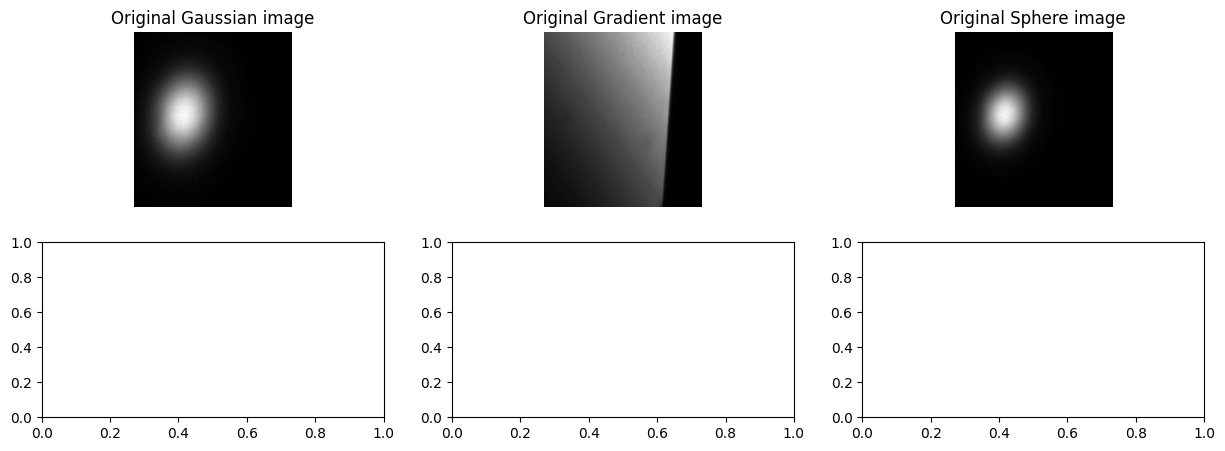

In [1023]:
# Plot the fits side to side with the original images
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

# Original images cropped to the ROI of the camera
ax[0, 0].imshow(first_frames['Gaussian'][ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]], cmap='gray')
ax[0, 0].set_title('Original Gaussian image')
ax[0, 0].axis('off')

ax[0, 1].imshow(first_frames['Gradient'][ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]], cmap='gray')
ax[0, 1].set_title('Original Gradient image')
ax[0, 1].axis('off')

ax[0, 2].imshow(first_frames['Sphere'][ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]], cmap='gray')
ax[0, 2].set_title('Original Sphere image')
ax[0, 2].axis('off')

# # Fitted images
# ax[1, 0].imshow(normalised_Gaussian_fit(fitted_gaussian.x), cmap='gray')
# ax[1, 0].set_title('Fitted Gaussian image')
# ax[1, 0].axis('off')

# ax[1, 1].imshow(gradient_fit(fitted_gradient.x), cmap='gray')
# ax[1, 1].set_title('Fitted Gradient image')
# ax[1, 1].axis('off')

# ax[1, 2].imshow(sphere_potential_fit(fitted_sphere.x), cmap='gray')
# ax[1, 2].set_title('Fitted Sphere image')
# ax[1, 2].axis('off')

plt.show()


In [1024]:
# Compute the residuals for the gaussian fit
first_frames_gauss_cropped = first_frames['Gaussian'][ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]]
residual_gaussian = first_frames_gauss_cropped - normalised_Gaussian_fit(first_frames_gauss_cropped, fitted_gaussian.x)

# Compute the relative standard deviation error for the gaussian fit
relative_error_gaussian = np.std(residual_gaussian) / np.mean(first_frames['Gaussian'][ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]])

# Compute the chi2 for the gaussian fit
chi2_gaussian = np.sum((residual_gaussian)**2) / np.std(residual_gaussian)**2

In [1025]:
# Compute residuals of Target Gaussient potential to the ED Gaussient potential
residual_gaussian_target = Gaussian_DMD_ED - Gaussian_DMD

# Compute the relative standard deviation error for the gaussian fit
relative_error_gaussian_target = np.std(residual_gaussian_target) / np.mean(Gaussian_DMD)

# Compute the chi2 for the gaussian fit
chi2_gaussian_target = np.sum((residual_gaussian_target)**2) / np.std(residual_gaussian_target)**2

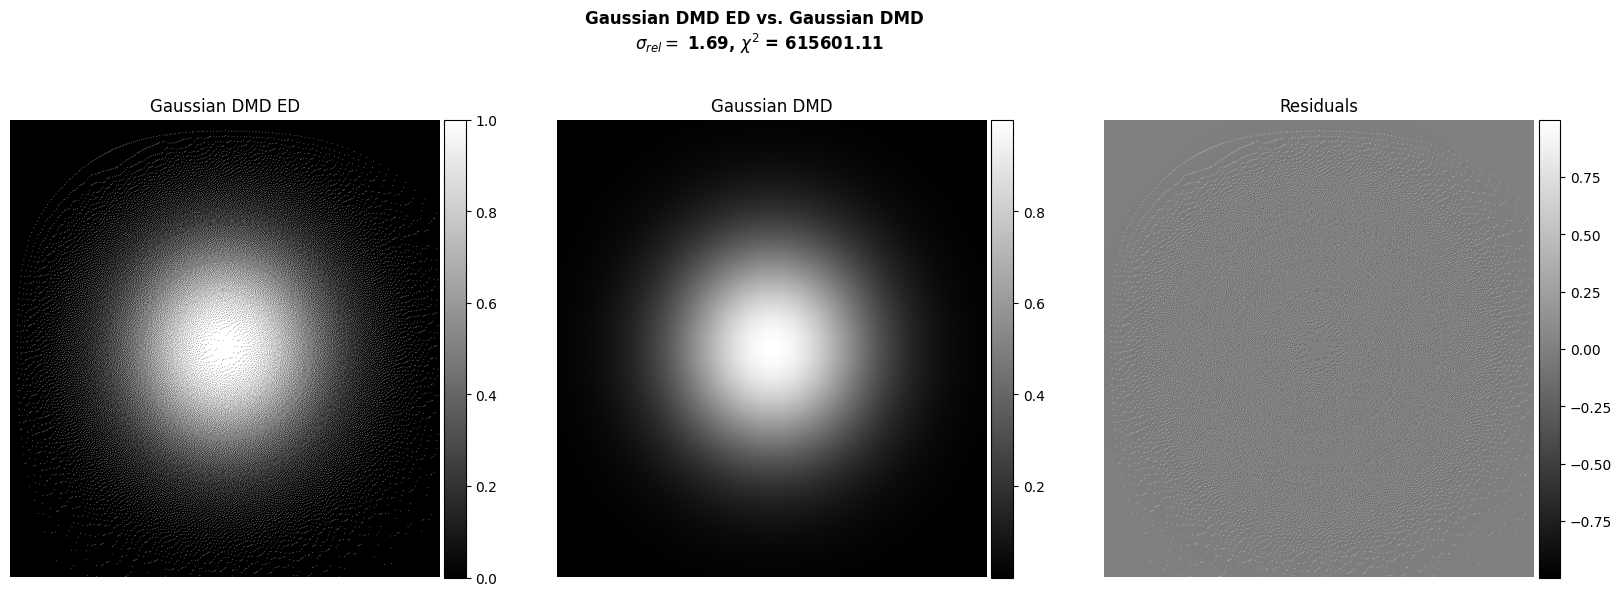

In [1026]:
# Plot side by side Gaussian DMD ED and Gaussian DMD and the residuals
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

ax[0].imshow(Gaussian_DMD_ED, cmap='gray')
ax[0].set_title('Gaussian DMD ED')
ax[0].axis('off')

ax[1].imshow(Gaussian_DMD, cmap='gray')
ax[1].set_title('Gaussian DMD')
ax[1].axis('off')

ax[2].imshow(residual_gaussian_target, cmap='gray')
ax[2].set_title('Residuals')
ax[2].axis('off')

divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[0].images[0], cax=cax0)

divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[1].images[0], cax=cax1)

divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[2].images[0], cax=cax2)

fig.suptitle(r'Gaussian DMD ED vs. Gaussian DMD '+' \n'+r'$\sigma_{rel} =$'+f' {relative_error_gaussian_target:.2f}, $\chi^2$ = {chi2_gaussian_target:.2f}', fontweight='bold')
plt.show()

In [1027]:
print(fitted_gaussian.x)

[ 8.31576636e+02  4.25610726e+00 -5.92225915e+00  6.14428479e+01
 -5.68022308e-02  1.37877600e-01  4.41754930e+02]


-0.056802230802400974
0.13787759960690316


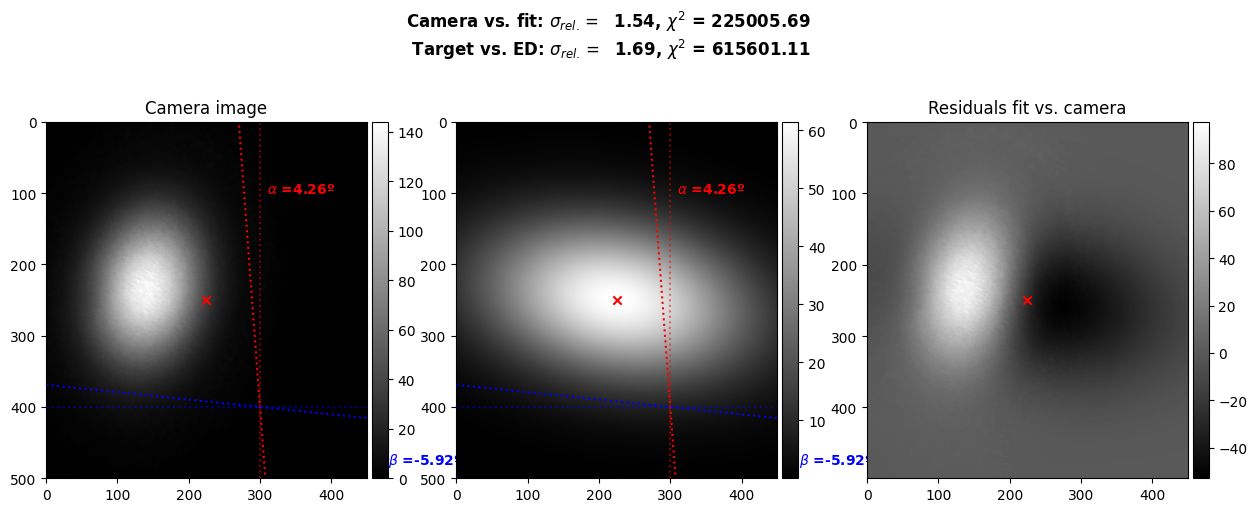

In [1028]:
M_guess = first_frames_gauss_cropped.shape[1]
N_guess = first_frames_gauss_cropped.shape[0]


# plot the original image, the fitted image and the residuals for the Gaussian image
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

im0 = ax[0].imshow(first_frames['Gaussian'][ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]], cmap='gray')
ax[0].set_title('Camera image')

# ax[0].axis('off')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, cax=cax0)

im1 = ax[1].imshow(normalised_Gaussian_fit(first_frames_gauss_cropped, fitted_gaussian.x), cmap='gray')
# ax[1].set_title(r'Fit ($\sigma_x$ = '+f'{fitted_gaussian.x[0]:.2f},' r'$\sigma_y$ = ' + f'{fitted_gaussian.x[6]:.2f})')
# ax[1].axis('off')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

im2 = ax[2].imshow(residual_gaussian, cmap='gray')
ax[2].set_title('Residuals fit vs. camera')
# ax[2].axis('off')
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

fig.suptitle('Camera vs. fit: '+r'$\sigma_{rel.} =$ ' +f' {relative_error_gaussian:.2f}, '+ r'$\chi^2$ = '+f'{chi2_gaussian:.2f} \n Target vs. ED: '+r'$\sigma_{rel.} =$ ' +f' {relative_error_gaussian_target:.2f}, '+ r'$\chi^2$ = '+f'{chi2_gaussian_target:.2f}', fontweight='bold')


alpha, beta = fitted_gaussian.x[1], fitted_gaussian.x[2]

# Benchmark the alpha angle
ax[0].axvline(x=300, color='r', linestyle=':', alpha=0.5)
ax[1].axvline(x=300, color='r', linestyle=':', alpha=0.5)


# Plot a line on ax[0], with the same slope as the fitted Gaussian passing through the center of the image
x_array_alpha = np.linspace(0, ROI_cam[3] - ROI_cam[2], 100)
y_array_alpha = (x_array_alpha - 300) * np.tan(np.radians(90-alpha)) + 400

# Plot the line
ax[0].plot(x_array_alpha, y_array_alpha, 'r:')
ax[1].plot(x_array_alpha, y_array_alpha, 'r:')

# Add text with the angle value
ax[0].text(310, 100, r'$\alpha$ ='+ f'{alpha:.2f}º', color='r', fontweight='bold')
ax[1].text(310, 100, r'$\alpha$ ='+ f'{alpha:.2f}º', color='r', fontweight='bold')

# Benchmark the beta angle
ax[0].axhline(y=400, color='blue', linestyle=':', alpha=0.5)
ax[1].axhline(y=400, color='blue', linestyle=':', alpha=0.5)

# Plot a line on ax[0], with the same slope as the fitted Gaussian passing through the center of the image
x_array_beta = np.linspace(0, ROI_cam[3] - ROI_cam[2], 100)
y_array_beta = np.empty_like(x_array_beta)
y_array_beta = -(x_array_beta - 300) * np.tan(np.radians(beta)) + 400

# Crop the plot to the image in ax[0] and ax[1]
ax[0].set_xlim(0, first_frames_gauss_cropped.shape[1])
ax[0].set_ylim(first_frames_gauss_cropped.shape[0], 0)

ax[1].set_xlim(0, first_frames_gauss_cropped.shape[1])
ax[1].set_ylim(first_frames_gauss_cropped.shape[0], 0)

# Plot the line
ax[0].plot(x_array_beta, y_array_beta, 'b:')
ax[1].plot(x_array_beta, y_array_beta, 'b:')

# Add text with the angle value
ax[0].text(480, 480, r'$\beta$ ='+ f'{beta:.2f}º', color='b', fontweight='bold')
ax[1].text(480, 480, r'$\beta$ ='+ f'{beta:.2f}º', color='b', fontweight='bold')

# Scatter a cross at the centroid x_0 y_0
x_0, y_0 = fitted_gaussian.x[4], fitted_gaussian.x[5]
print(x_0)
print(y_0)
x_0 += (ROI_cam[3] - ROI_cam[2]) / 2
y_0 += (ROI_cam[1] - ROI_cam[0]) / 2

ax[0].scatter(x_0, y_0, marker='x', color='r')
ax[1].scatter(x_0, y_0, marker='x', color='r')
ax[2].scatter(x_0, y_0, marker='x', color='r')

plt.show()

#### Generate corrected ED image

In [ ]:
# Retrieve the fitted parameters
fit_param = fitted_gaussian.x # sigma, alpha, beta, gamma
print(fitted_gaussian.x)

[234.07763057  55.83280271  47.80270839 120.15947232   2.78322473
  -1.94053169 284.4057464 ]


In [476]:
## CAUTION - OLD VERSION

def normalised_Gaussian_corr(sigma, alpha, beta):

    sigma_y = sigma*(1-np.tan(np.radians(alpha)/np.tan(np.radians(beta))))
    x = np.linspace(-3.5*sigma, 3.5*sigma, Mpx)
    y = np.linspace(-3.5*sigma, 3.5*sigma, Npx)
    X, Y = np.meshgrid(x, y)
    X_new = X + Y * np.tan(np.radians(alpha))
    Y_new = Y + X * np.tan(np.radians(beta))
    Z = np.exp(-((X_new**2 + Y_new**2) / (2.0 * sigma**2)))
    return Z

In [477]:
corrected_gaussian = normalised_Gaussian_corr(100, fit_param[1], fit_param[2])

In [478]:
# Generate ED from the corrected gaussian image
corrected_gaussian_ED = perform_error_diffusion(corrected_gaussian, error_diffusion_set)

# Embed the corrected ED image in the padding
image_corrected_Gaussian = np.zeros((N, M))
image_corrected_Gaussian[N_min:N_max, M_min:M_max] = corrected_gaussian_ED

(-0.5, 759.5, 809.5, -0.5)

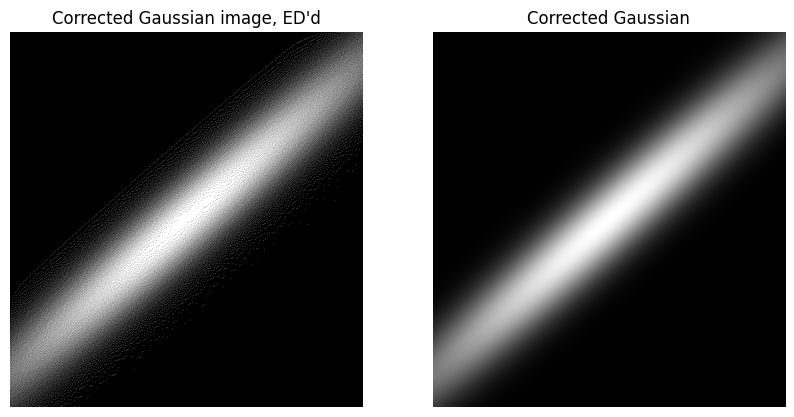

In [479]:
# Plot the two images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(corrected_gaussian_ED, cmap='gray')
ax[0].set_title("Corrected Gaussian image, ED'd")
ax[0].axis('off')

ax[1].imshow(corrected_gaussian, cmap='gray')
ax[1].set_title('Corrected Gaussian')
ax[1].axis('off')


In [409]:
# Save the corrected DMD image in PNG
Image.fromarray((image_corrected_Gaussian*255).astype(np.uint8)).save('./ED_Potentials/Corrected_Gaussian_2001.png')

#### Analysis of the corrected image

In [ ]:
# Load the corrected image - elliptical
corrected_gaussian_elliptical = Image.open('./Corrected_potentials_Images/Gaussian_elliptical.bmp')
corrected_gaussian_elliptical = np.array(corrected_gaussian_elliptical)

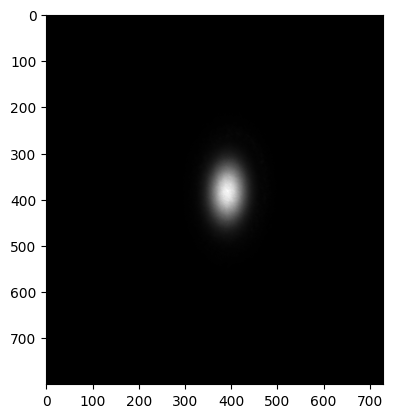

In [29]:
plt.imshow(corrected_gaussian_elliptical[ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]], cmap='gray')

In [1082]:
# Define another fit function
def normalised_Gaussian_fit_XY(image, arg):
    sigmaX, sigmaY, gamma, x_0, y_0 = arg[0], arg[1], arg[2], arg[3], arg[4]

    N_guess = image.shape[0]
    M_guess = image.shape[1]

    x = np.linspace(-1000, 1000, M_guess)
    y = np.linspace(-1000, 1000, N_guess)

    X, Y = np.meshgrid(x, y)
    Z = gamma*np.exp(-((X - x_0*np.ones_like(X)**2) / (2.0 * sigmaX**2))) * np.exp(-(((Y-y_0*np.ones_like(Y))**2) / (2.0 * sigmaY**2)))
    return Z

# Define another fit function
def normalised_Gaussian_fit_sym(image, arg):
    sigma, gamma, x_0, y_0 = arg[0], arg[1], arg[2], arg[3]

    N_guess = image.shape[0]
    M_guess = image.shape[1]

    x = np.linspace(-1000, 1000, M_guess)
    y = np.linspace(-1000, 1000, N_guess)

    X, Y = np.meshgrid(x, y)
    Z = gamma*np.exp(-((X - x_0)**2) / (2.0 * sigma**2)) * np.exp(-(((Y-y_0)**2) / (2.0 * sigma**2)))
    return Z

In [1065]:
# Fit the images(copy, for conveinence)

def fit_image(image, fit_function, initial_guess):

    # crop image to the wanted ROI
    image = image[ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]]


    # Define the error function
    def error_function(arg):
        Z_fit = fit_function(image, arg)
        return np.sum((image - Z_fit)**2)

    # Perform the fit
    result = minimize(error_function, initial_guess, method='Nelder-Mead')

    # Return the result
    return result

In [482]:
# Fit this thing to a gaussian
fitted_gaussian_elliptical = fit_image(corrected_gaussian_elliptical, normalised_Gaussian_fit_XY, [20, 100, 1, 0, 0])

# Compute the residuals for the gaussian fit
first_frames_gauss_cropped = corrected_gaussian_elliptical[ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]]
residual_gaussian_elliptical = first_frames_gauss_cropped - normalised_Gaussian_fit_XY(first_frames_gauss_cropped, fitted_gaussian_elliptical.x)

# Compute the relative standard deviation error for the gaussian fit
relative_error_gaussian_elliptical = np.std(residual_gaussian_elliptical) / np.mean(first_frames_gauss_cropped)

# Compute the chi2 for the gaussian fit
chi2_gaussian_elliptical = np.sum((residual_gaussian_elliptical)**2) / np.std(residual_gaussian_elliptical)**2


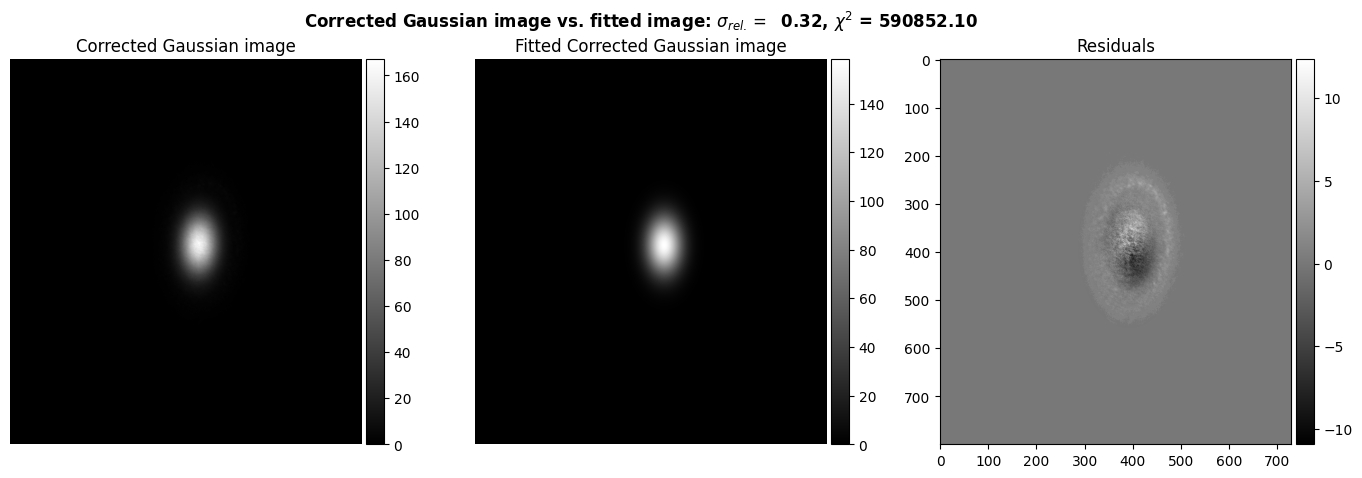

In [483]:
# Print the fit side to side with the original image
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

ax[0].imshow(corrected_gaussian_elliptical[ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]], cmap='gray')
ax[0].set_title('Corrected Gaussian image')
ax[0].axis('off')

ax[1].imshow(normalised_Gaussian_fit_XY(corrected_gaussian_elliptical[ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]], fitted_gaussian_elliptical.x), cmap='gray')
ax[1].set_title('Fitted Corrected Gaussian image')
ax[1].axis('off')

ax[2].imshow(residual_gaussian_elliptical, cmap='gray')
ax[2].set_title('Residuals')
fig.suptitle('Corrected Gaussian image vs. fitted image: '+r'$\sigma_{rel.} =$ ' +f' {relative_error_gaussian_elliptical:.2f}, '+ r'$\chi^2$ = '+f'{chi2_gaussian_elliptical:.2f}', fontweight='bold')

divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[0].images[0], cax=cax0)

divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[1].images[0], cax=cax1)

divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[2].images[0], cax=cax2)


In [484]:
print(fitted_gaussian_elliptical.x)

[ 68.30110811 101.35479884 158.2046198   75.06729082 -33.77705278]


In [485]:
# Import the other image
corrected_gaussian_round = Image.open('./Corrected_potentials_Images/Gaussian_2000.bmp')
corrected_gaussian_round = np.array(corrected_gaussian_round)

In [564]:
# fit the image
fitted_gaussian_round = fit_image(corrected_gaussian_round, normalised_Gaussian_fit_sym, [100, 100, 0, 0])

# Compute the residuals for the gaussian fit
first_frames_gauss_cropped = corrected_gaussian_round[ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]]
residual_gaussian_round = first_frames_gauss_cropped - normalised_Gaussian_fit_sym(first_frames_gauss_cropped, fitted_gaussian_round.x)

# Compute the relative standard deviation error for the gaussian fit
relative_error_gaussian_round = np.std(residual_gaussian_round) / np.mean(first_frames_gauss_cropped)

# Compute the chi2 for the gaussian fit
chi2_gaussian_round = np.sum((residual_gaussian_round)**2) / np.std(residual_gaussian_round)**2

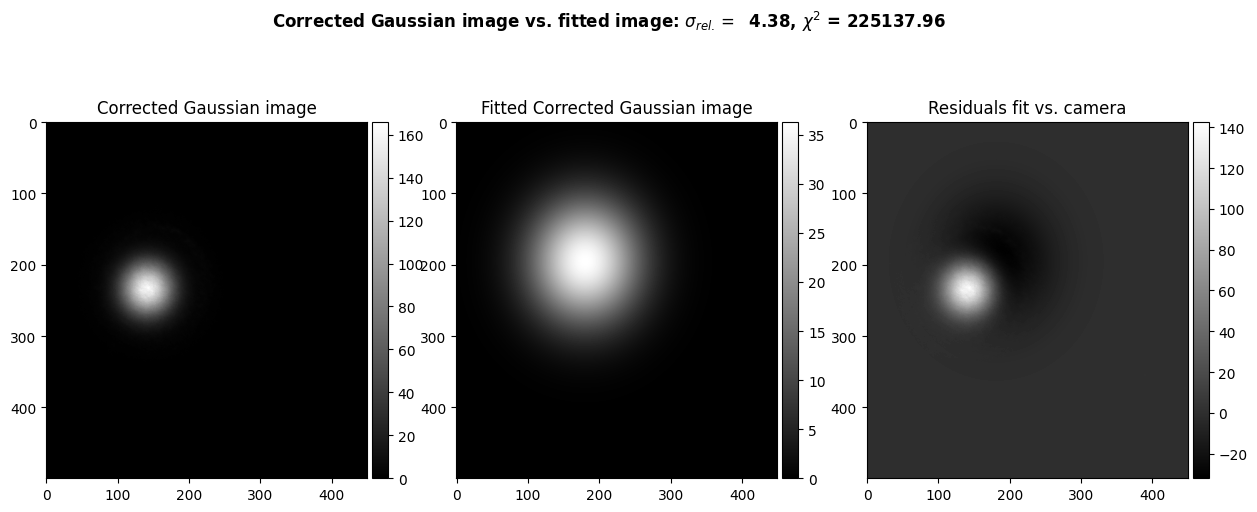

In [565]:
# plot the original image, the fitted image and the residuals for the Gaussian image
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

ax[0].imshow(corrected_gaussian_round[ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]], cmap='gray')
ax[0].set_title('Corrected Gaussian image')

# ax[0].axis('off')

ax[1].imshow(normalised_Gaussian_fit_sym(first_frames_gauss_cropped, fitted_gaussian_round.x), cmap='gray')
ax[1].set_title('Fitted Corrected Gaussian image')
# ax[1].axis('off')

ax[2].imshow(residual_gaussian_round, cmap='gray')
ax[2].set_title('Residuals fit vs. camera')
# ax[2].axis('off')

fig.suptitle('Corrected Gaussian image vs. fitted image: '+r'$\sigma_{rel.} =$ ' +f' {relative_error_gaussian_round:.2f}, '+ r'$\chi^2$ = '+f'{chi2_gaussian_round:.2f}', fontweight='bold')

# add colorbars

divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[0].images[0], cax=cax0)

divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[1].images[0], cax=cax1)

divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[2].images[0], cax=cax2)



#### Calibration with quadratic fit on randomly generated patterns (see Run #3)
I am gonna redo the whole pipeline with the calibration, so:
+ Generate the gaussian potential, without any correction whatsoever
+ Fit that to a tilted gaussian, retrieve the values of alpha and beta
+ Derive the corrected potential

In [54]:
A = 0.17
B = 0.83

poly = np.poly1d([A, B, 0])

Text(0.5, 1.0, 'Calibration curve')

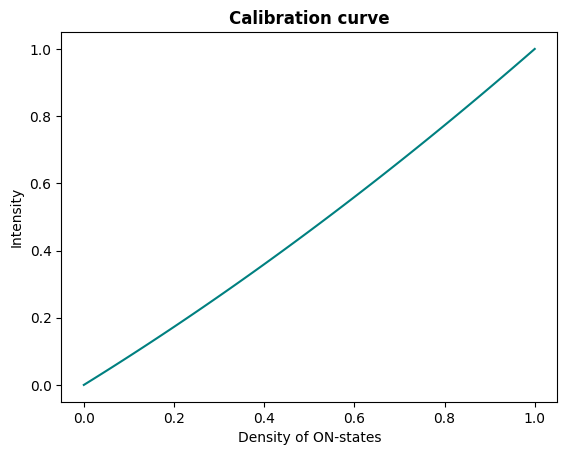

In [55]:
# plot the polynomial on [0,1]
x = np.linspace(0, 1, 100)
y = poly(x)

plt.plot(x, y, color='teal')
plt.xlabel('Density of ON-states')
plt.ylabel('Intensity')
plt.title('Calibration curve', fontweight='bold')

In [56]:
def calibration_function(y, A, B):
    # y is the intensity
    roots = np.roots([A, B, -y])

    # Return the root that is between 0 and 1
    for root in roots:
        if root > 0 and root < 1:
            return root

In [57]:
# Create Gaussian potential
gauss_potential = normalised_Gaussian(Npx, Mpx, 100)
gauss_potential_calibrated = np.empty_like(gauss_potential)

for i in range(len(gauss_potential[:,0])):
    for j in range(len(gauss_potential[0,:])):
        gauss_potential_calibrated[i,j] = calibration_function(gauss_potential[i,j], A, B)

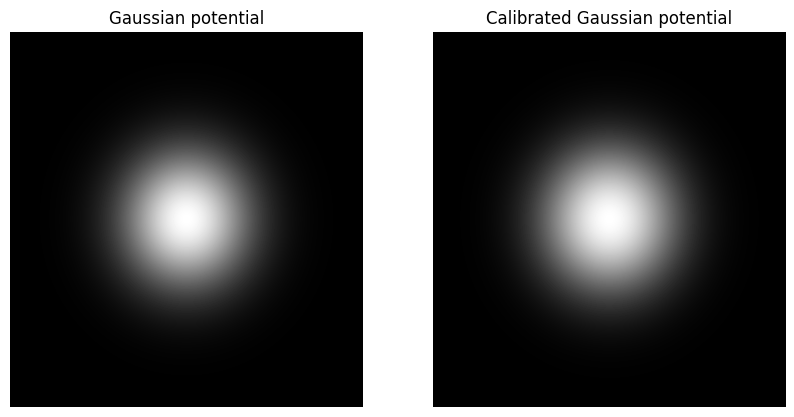

In [58]:
# Plot the two images side by side

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(gauss_potential, cmap='gray')
ax[0].set_title('Gaussian potential')
ax[0].axis('off')

ax[1].imshow(gauss_potential_calibrated, cmap='gray')
ax[1].set_title('Calibrated Gaussian potential')
ax[1].axis('off')

plt.show()

In [778]:
# Perform ED on both of them
gauss_potential_ED = perform_error_diffusion(gauss_potential, error_diffusion_set)
gauss_potential_calibrated_ED = perform_error_diffusion(gauss_potential_calibrated, error_diffusion_set)

(-0.5, 759.5, 809.5, -0.5)

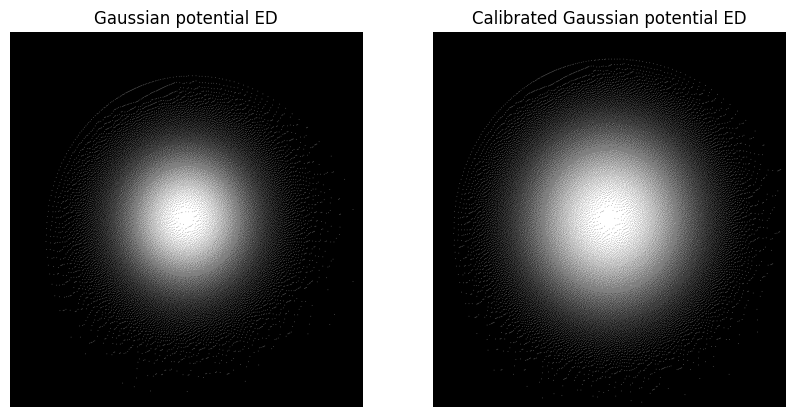

In [779]:
# Plot them side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(gauss_potential_ED, cmap='gray')
ax[0].set_title('Gaussian potential ED')
ax[0].axis('off')

ax[1].imshow(gauss_potential_calibrated_ED, cmap='gray')
ax[1].set_title('Calibrated Gaussian potential ED')
ax[1].axis('off')



In [525]:
# Embed the calibrated one in the padding
image_calibrated_Gaussian = np.zeros((N, M))
image_calibrated_Gaussian[N_min:N_max, M_min:M_max] = gauss_potential_calibrated_ED

In [526]:
# Export the calibrated Gaussian potential to a PNG file
Image.fromarray((image_calibrated_Gaussian*255).astype(np.uint8)).save('./ED_Potentials/Calibrated_Gaussian.png')

In [780]:
ROI_cam = (1250, 1750, 1950, 2400)

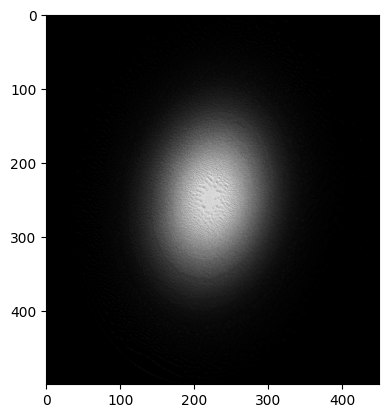

In [781]:
calib_image = Image.open('./Calibrated_Images/Calibrated Gaussian unprocessed.bmp')
calib_image = np.array(calib_image)
calib_image_cropped = calib_image[ROI_cam[0]:ROI_cam[1], ROI_cam[2]:ROI_cam[3]]

plt.imshow(calib_image_cropped, cmap='gray')

In [1097]:
fit_params_calib = fit_image(calib_image, normalised_Gaussian_fit, [100, 0.1, 0.1, 1, 0, 0, 100])

In [1098]:
# Compute residuals
residual_calib = calib_image_cropped - normalised_Gaussian_fit(calib_image_cropped, fit_params_calib.x)

# Compute relative standard error
relative_error_calib = np.std(residual_calib) / np.mean(calib_image_cropped)

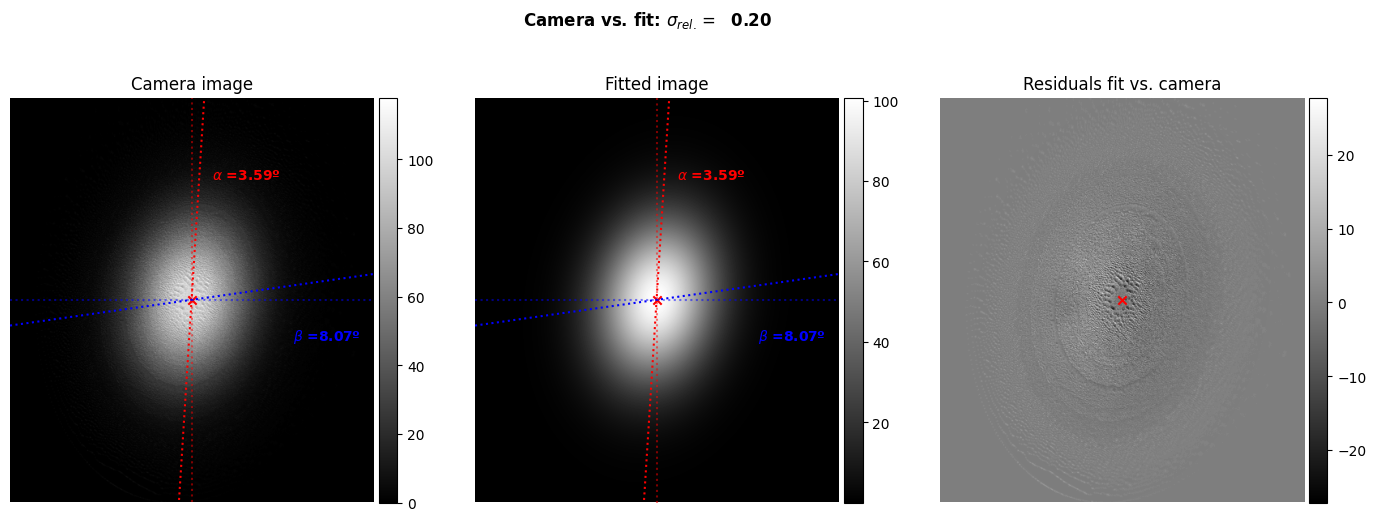

In [1099]:
M_guess = calib_image_cropped.shape[1]
N_guess = calib_image_cropped.shape[0]


# plot the original image, the fitted image and the residuals for the Gaussian image
fig, ax = plt.subplots(1, 3, figsize=(17, 6))

im0 = ax[0].imshow(calib_image_cropped, cmap='gray')
ax[0].set_title('Camera image')

ax[0].axis('off')
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, cax=cax0)

im1 = ax[1].imshow(normalised_Gaussian_fit(calib_image_cropped, fit_params_calib.x), cmap='gray')
# ax[1].set_title(r'Fit ($\sigma_x$ = '+f'{fit_params_calib.x[0]:.2f},' r'$\sigma_y$ = ' + f'{fit_params_calib.x[6]:.2f})')
ax[1].set_title('Fitted image')
ax[1].axis('off')
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1)

im2 = ax[2].imshow(residual_calib, cmap='gray')
ax[2].set_title('Residuals fit vs. camera')
ax[2].axis('off')
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2)

fig.suptitle('Camera vs. fit: '+r'$\sigma_{rel.} =$ ' +f' {relative_error_calib:.2f}', fontweight='bold')


alpha, beta, x0, y0 = fit_params_calib.x[1], fit_params_calib.x[2], fit_params_calib.x[4], fit_params_calib.x[5]

x0 += (ROI_cam[3] - ROI_cam[2]) / 2
y0 += (ROI_cam[1] - ROI_cam[0]) / 2

# Benchmark the alpha angle
ax[0].axvline(x=x0, color='r', linestyle=':', alpha=0.5)
ax[1].axvline(x=x0, color='r', linestyle=':', alpha=0.5)


# Plot a line on ax[0], with the same slope as the fitted Gaussian passing through the center of the image
x_array_alpha = np.linspace(0, ROI_cam[3] - ROI_cam[2], 100)
y_array_alpha = -(x_array_alpha - x0) * np.tan(np.radians(90-alpha)) + y0 # minus sign because the y axis goes downards

# Plot the line
ax[0].plot(x_array_alpha, y_array_alpha, 'r:')
ax[1].plot(x_array_alpha, y_array_alpha, 'r:')

# Add text with the angle value
ax[0].text(250, 100, r'$\alpha$ ='+ f'{alpha:.2f}º', color='r', fontweight='bold')
ax[1].text(250, 100, r'$\alpha$ ='+ f'{alpha:.2f}º', color='r', fontweight='bold')

# Benchmark the beta angle
ax[0].axhline(y=y0, color='blue', linestyle=':', alpha=0.5)
ax[1].axhline(y=y0, color='blue', linestyle=':', alpha=0.5)

# Plot a line on ax[0], with the same slope as the fitted Gaussian passing through the center of the image
x_array_beta = np.linspace(0, ROI_cam[3] - ROI_cam[2], 100)
y_array_beta = np.empty_like(x_array_beta)
y_array_beta = -(x_array_beta - x0) * np.tan(np.radians(beta)) + y0 # minus sign because the y axis goes downards

# Crop the plot to the image in ax[0] and ax[1]
ax[0].set_xlim(0, calib_image_cropped.shape[1])
ax[0].set_ylim(calib_image_cropped.shape[0], 0)

ax[1].set_xlim(0, calib_image_cropped.shape[1])
ax[1].set_ylim(calib_image_cropped.shape[0], 0)

# Plot the line
ax[0].plot(x_array_beta, y_array_beta, 'b:')
ax[1].plot(x_array_beta, y_array_beta, 'b:')

# Add text with the angle value
ax[0].text(350, 300, r'$\beta$ ='+ f'{beta:.2f}º', color='b', fontweight='bold')
ax[1].text(350, 300, r'$\beta$ ='+ f'{beta:.2f}º', color='b', fontweight='bold')

# Scatter a cross at the centroid x_0 y_0

ax[0].scatter(x0, y0, marker='x', color='r')
ax[1].scatter(x0, y0, marker='x', color='r')
ax[2].scatter(x0, y0, marker='x', color='r')

plt.show()

In [731]:
# # Plot the fitted image again
# fig = plt.figure(figsize=(10, 10))
# custom_params = fit_params_calib.x
# print(custom_params)
# custom_params[0], custom_params[-1] = 400,400 # Checking what's happening if I set both sigmas to 100. Can I get a round shape? If yes, then the distortion does not come only from a tilt.
# plt.imshow(normalised_Gaussian_fit(calib_image_cropped, fit_params_calib.x), cmap='gray')


In [689]:
def normalised_Gaussian_corr_2(alpha, beta, sigma):

    # sigmaX = sigma*(np.tan(beta)/(1+ np.tan(beta)*np.tan(alpha))) * (1 / np.sin(beta) - 1 / np.cos(alpha))
    # sigmaY = sigma*(np.tan(alpha)/(1+ np.tan(beta)*np.tan(alpha))) * (1 / np.cos(beta) + 1 / np.sin(alpha))

    sigmaY = sigma*(np.tan(beta)/(1+ np.tan(beta)*np.tan(alpha))) * (1 / np.sin(beta) - 1 / np.cos(alpha))
    sigmaX = sigma*(np.tan(alpha)/(1+ np.tan(beta)*np.tan(alpha))) * (1 / np.cos(beta) + 1 / np.sin(alpha))
    print(sigmaX, sigmaY)

    # sigmaX = sigma * (np.cos(beta) + np.sin(beta))
    # sigmaY = sigma * (np.cos(alpha) + np.sin(alpha))
    x = np.linspace(-1500, 1500, Mpx)
    y = np.linspace(-1500, 1500, Npx)

    X, Y = np.meshgrid(x, y)
    X_new = X  * np.cos(np.radians(beta)) + Y * np.sin(np.radians(beta))
    Y_new =  -X * np.sin(np.radians(alpha)) + Y * np.cos(np.radians(alpha))

    Z = np.exp(-((X_new**2) / (2.0 * sigmaX**2))) * np.exp(-((Y_new**2) / (2.0 * sigmaY**2)))
    
    return Z

In [62]:
def normalised_Gaussian_corr_3(alpha, beta, sigma):

    x = np.linspace(-1500, 1500, Mpx)
    y = np.linspace(-1500, 1500, Npx)

    sigmaX = sigma*1.46
    X, Y = np.meshgrid(x, y)
    X_new = np.tan(beta)/(1 + np.tan(beta)*np.tan(alpha)) * ( X / np.sin(beta) - Y / np.cos(alpha))
    Y_new = np.tan(alpha)/(1 + np.tan(beta)*np.tan(alpha)) * ( X / np.cos(beta) + Y / np.sin(alpha))

    Z = np.exp(-((X_new**2) / (2.0 * sigmaX**2))) * np.exp(-((Y_new**2) / (2.0 * sigma**2)))
    return Z
    

In [81]:
# alpha_test = np.deg2rad(3.59)
# beta_test = np.deg2rad(8.07)

# alpha_test = np.deg2rad(-36.43)
# beta_test = np.deg2rad(-22.75)

# Manual fitting
alpha_test = np.deg2rad(4.5)
beta_test = np.deg2rad(-2.3)

In [82]:
print((np.tan(alpha_test)/(1+ np.tan(beta_test)*np.tan(alpha_test))) * (1 / np.cos(beta_test) + 1  / np.sin(alpha_test)))
print((np.tan(beta_test)/(1+ np.tan(beta_test)*np.tan(alpha_test))) * (1 / np.sin(beta_test) - 1 / np.cos(alpha_test)))

1.0852879400587072
1.044395920904859


In [83]:
gaussian_detilted = normalised_Gaussian_corr_3(alpha_test, beta_test, 300)
gaussian_detilted_calibrated = np.empty_like(gaussian_detilted)

for i in range(len(gaussian_detilted[:,0])):
    for j in range(len(gaussian_detilted[0,:])):
        gaussian_detilted_calibrated[i,j] = 0.9*calibration_function(gaussian_detilted[i,j], A, B)

(-0.5, 759.5, 809.5, -0.5)

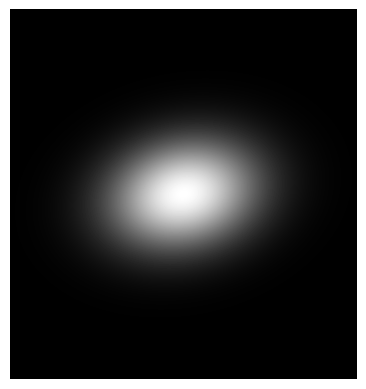

In [84]:
plt.imshow(gaussian_detilted, cmap='gray')
plt.axis('off')

In [85]:
# Run the error diffusion algo on it
corrected_round_image_ED = perform_error_diffusion(gaussian_detilted_calibrated, error_diffusion_set)

In [86]:
# Embed the corrected image in the padding
image_corrected_round = np.zeros((N, M))
image_corrected_round[N_min:N_max, M_min:M_max] = corrected_round_image_ED

# Save the corrected DMD image in PNG
Image.fromarray((image_corrected_round*255).astype(np.uint8)).save('./ED_Potentials/Corrected_Gaussian_round_achro_3.png')

#### Using the all-on image to have better intuition on the fitting algorithm
Initially, this was the reason why I thought that the transformation needed to be "parallelogram-like". For this reason, I thought that the values $\alpha = 3.59º$ and $\beta = 8.07º$ made sense.

In [875]:
# Size of the all-on image
N_min = 200
N_max = 1010
M_min = 570
M_max = 1330

N_px = N_max - N_min
M_px = M_max - M_min
print(N_px, M_px)

810 760


In [11]:
# Load the image fo the all-on state
all_on_image = Image.open('./Achromats/square_middle_brighter.bmp')
all_on_image = np.array(all_on_image)

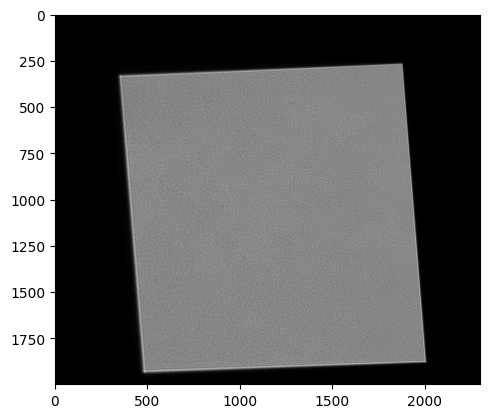

In [15]:
# Display image
ROI_cam_p = (1000, 2999, 200, 2500)
plt.imshow(all_on_image[ROI_cam_p[0]:ROI_cam_p[1], ROI_cam_p[2]:ROI_cam_p[3]], cmap='gray')


In [866]:
# Define the parallelogram function
def parallelogram(im, alpha, beta, i0, j0, cx, cy):
    # i0, j0 bottom left corner (top left if look at it with imshow, Y axis is going downards)

    output = np.zeros_like(im)

    # Define the borders of the parllelogram
    def left(j): return (j-j0) * np.tan(np.pi/2-alpha) + i0
    def right(j): return (j-j0-cx) * np.tan(np.pi/2-alpha) + i0
    def top(j): return (j-j0) * np.tan(beta) + i0 + cy
    def bottom(j): return (j-j0) * np.tan(beta) + i0

    for j in range(int(j0), im.shape[1]):
        for i in range(int(i0), im.shape[0]):
            if i < left(j) and i > right(j) and i > bottom(j) and i < top(j):
                output[i,j] = 1
    return output

(0.0, 3000.0)

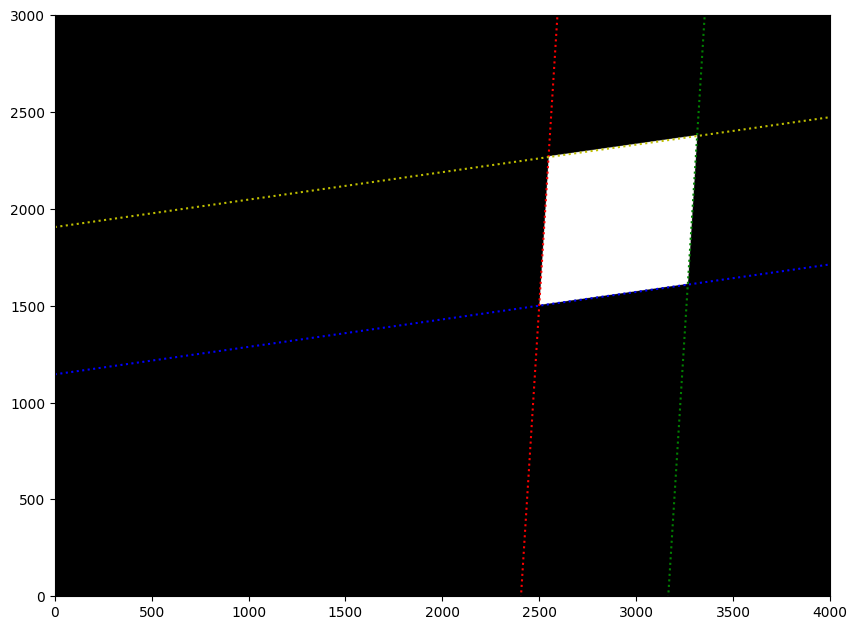

In [ ]:
parallelogram_test = parallelogram(all_on_image, np.deg2rad(3.59), np.deg2rad(8.07), 1500, 2500, 760, 760)
fig = plt.figure(figsize=(10, 10))

# Print the thing
plt.imshow(parallelogram_test, cmap='gray')
x = np.linspace(0, all_on_image.shape[1], 100)
plt.plot(x, (x-2500)* np.tan(np.radians(90-3.59)) + 1500, 'r:')
plt.plot(x, (x-2500) * np.tan(np.radians(8.07)) + 1500, 'b:')
plt.plot(x, (x-2500-760)* np.tan(np.radians(90-3.59)) + 1500, 'g:')
plt.plot(x, (x-2500) * np.tan(np.radians(8.07)) + 1500 + 760, 'y:')


# crop to the all_on_image size
plt.xlim(2000, all_on_image.shape[1])
plt.ylim(0, all_on_image.shape[0])

In [872]:
# Define the parallelogram fit function
def parallelogram_fit(DNref, DMref, im):

    # Crop the image to the ROI of the camera
    im_cropped = im[ROI_cam_p[0]:ROI_cam_p[1], ROI_cam_p[2]:ROI_cam_p[3]]

    # Define the parallelogram function
    def parallelogram_arg(arg):
        alpha, beta, i0, j0, gamma = arg[0], arg[1], arg[2], arg[3], arg[4]
        return parallelogram(im_cropped, alpha, beta, i0, j0, gamma*DNref, gamma*DMref)
    
    # Define the error function
    def error_function(arg):
        Z_fit = parallelogram_arg(arg)
        return np.sum((im_cropped - Z_fit)**2)
    
    # i_init = int((ROI_cam_p[1] - ROI_cam_p[0]) // 2)
    # j_init = int((ROI_cam_p[3] - ROI_cam_p[2]) // 2)

    i_init = 300
    j_init = 250
    # Perform the fit
    result = minimize(error_function, [0, 0, i_init, j_init, 1], method='Nelder-Mead')

    return result

In [873]:
fit_params__parallelogram = parallelogram_fit(N_px, M_px, all_on_image)
print(fit_params__parallelogram)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 30461899.0
             x: [ 6.127e-04  3.836e-04  2.732e+02  2.713e+02  6.683e-01]
           nit: 68
          nfev: 198
 final_simplex: (array([[ 6.127e-04,  3.836e-04, ...,  2.713e+02,
                         6.683e-01],
                       [ 6.127e-04,  3.836e-04, ...,  2.713e+02,
                         6.683e-01],
                       ...,
                       [ 6.127e-04,  3.836e-04, ...,  2.713e+02,
                         6.683e-01],
                       [ 6.127e-04,  3.836e-04, ...,  2.713e+02,
                         6.683e-01]]), array([ 3.046e+07,  3.046e+07,  3.046e+07,  3.046e+07,
                        3.046e+07,  3.046e+07]))


Text(0.5, 0.98, 'Parallelogram fit: $\\sigma_{rel.} =$  3.18')

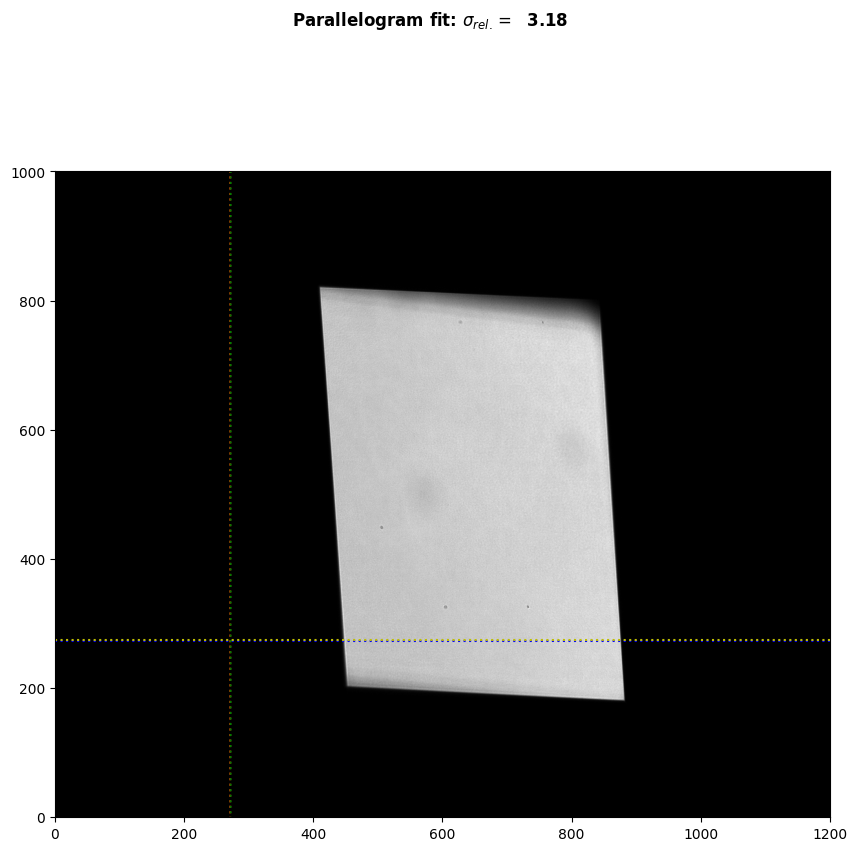

In [876]:
# plot the left, right, top and bottom lines on im_cropped
fig = plt.figure(figsize=(10, 10))

# Print the thing
all_on_image_cropped = all_on_image[ROI_cam_p[0]:ROI_cam_p[1], ROI_cam_p[2]:ROI_cam_p[3]]
plt.imshow(all_on_image_cropped, cmap='gray')
x = np.linspace(0, all_on_image_cropped.shape[1], 100)
plt.plot(x, (x-fit_params__parallelogram.x[3])* np.tan(np.radians(90-fit_params__parallelogram.x[0])) + fit_params__parallelogram.x[2], 'r:')
plt.plot(x, (x-fit_params__parallelogram.x[3]) * np.tan(np.radians(fit_params__parallelogram.x[1])) + fit_params__parallelogram.x[2], 'b:')
plt.plot(x, (x-fit_params__parallelogram.x[3]-fit_params__parallelogram.x[4])* np.tan(np.radians(90-fit_params__parallelogram.x[0])) + fit_params__parallelogram.x[2], 'g:')
plt.plot(x, (x-fit_params__parallelogram.x[3]) * np.tan(np.radians(fit_params__parallelogram.x[1])) + fit_params__parallelogram.x[2] + fit_params__parallelogram.x[4], 'y:')

# crop to the all_on_image size
plt.xlim(0, all_on_image_cropped.shape[1])
plt.ylim(0, all_on_image_cropped.shape[0])

# Compute the residuals for the parallelogram fit
residual_parallelogram = all_on_image_cropped - parallelogram(all_on_image_cropped, fit_params__parallelogram.x[0], fit_params__parallelogram.x[1], fit_params__parallelogram.x[2], fit_params__parallelogram.x[3], fit_params__parallelogram.x[4]*N_px, fit_params__parallelogram.x[4]*M_px)

# Compute the relative standard deviation error for the parallelogram fit
relative_error_parallelogram = np.std(residual_parallelogram) / np.mean(all_on_image_cropped)

# Title
plt.suptitle('Parallelogram fit: '+r'$\sigma_{rel.} =$ ' +f' {relative_error_parallelogram:.2f}', fontweight='bold')

(1999.0, 0.0)

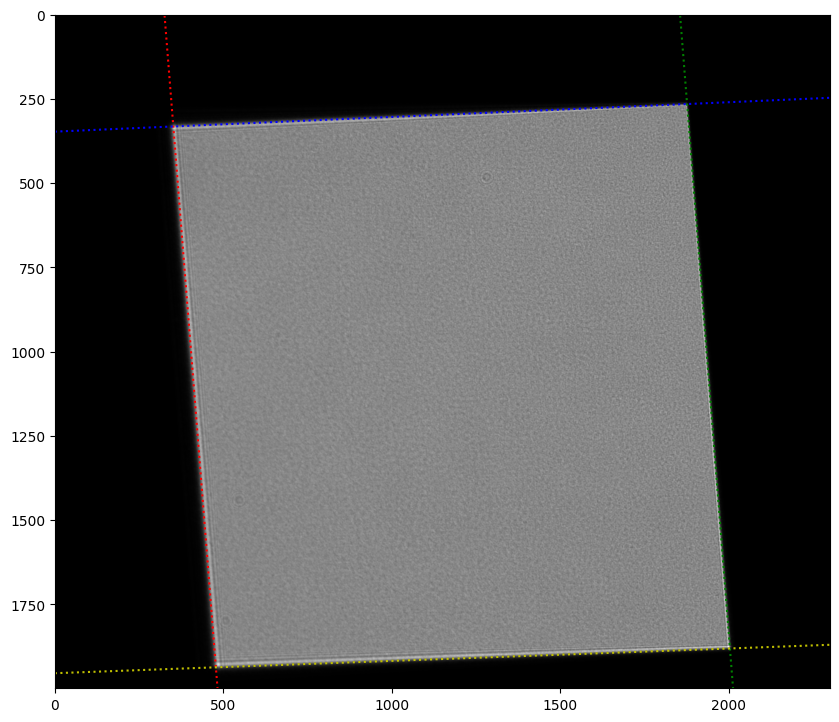

In [50]:
# Manual fit

fig = plt.figure(figsize=(10, 10))

# Print the thing
all_on_image_cropped = all_on_image[ROI_cam_p[0]:ROI_cam_p[1], ROI_cam_p[2]:ROI_cam_p[3]]
plt.imshow(all_on_image_cropped, cmap='gray')
x = np.linspace(0, all_on_image_cropped.shape[1], 100)

# minus signs because the y axis is flipped
plt.plot(x, -(x-390)* np.tan(np.radians(90+4.5)) + 820, 'r:') # left
plt.plot(x, -(x-390) * np.tan(np.radians(2.5)) + 330, 'b:') # top
plt.plot(x, -(x-1920)* np.tan(np.radians(90+4.5)) + 820, 'g:') # right
plt.plot(x, -(x-390) * np.tan(np.radians(2.1)) + 1940, 'y:') # bottom
# crop to the all_on_image size
plt.xlim(0, all_on_image_cropped.shape[1])
plt.ylim(all_on_image_cropped.shape[0], 0)
# plt.axes('off')

# Compute residuals for these values of alpha, beta, i, j, gamma
# residuals_parallelogram_manual = all_on_image_cropped - parallelogram(all_on_image_cropped, np.deg2rad(3.8), np.deg2rad(3), 820, 403, 439, -615)
# relative_error_parallelogram_manual = np.std(residuals_parallelogram_manual) / np.mean(all_on_image_cropped)

# plt.imshow(parallelogram(all_on_image_cropped, -np.deg2rad(3.8), -np.deg2rad(3), 820, 403, 439, 615), cmap='gray')
# Title
# plt.suptitle('Parallelogram fit: '+r'$\sigma_{rel.} =$ ' +f' {relative_error_parallelogram_manual:.2f}', fontweight='bold')

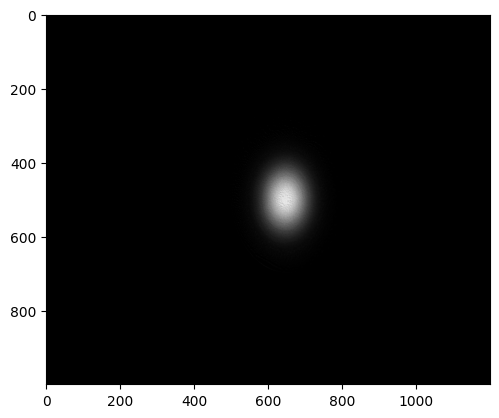

In [1088]:
# Open image
straight_image = Image.open('./Calibrated_Images/alpha_neg.bmp')
straight_image = np.array(straight_image)
plt.imshow(straight_image[ROI_cam_p[0]:ROI_cam_p[1], ROI_cam_p[2]:ROI_cam_p[3]], cmap='gray')
straight_image_cropped = straight_image[ROI_cam_p[0]:ROI_cam_p[1], ROI_cam_p[2]:ROI_cam_p[3]]

#### Final Fittings

In [ ]:
# ROI_cam
ROI_final = (1300, 1700, 1900, 2400)

In [1139]:
# Load images
straight_image = Image.open('./Calibrated_Images/alpha_neg.bmp')
straight_image = np.array(straight_image)
straight_image_cropped = straight_image[ROI_final[0]:ROI_final[1], ROI_final[2]:ROI_final[3]]

round_image = Image.open('./Calibrated_Images/round_gaussian_alpha_pos.bmp')
round_image = np.array(round_image)
round_image_cropped = round_image[ROI_final[0]:ROI_final[1], ROI_final[2]:ROI_final[3]]

Text(0.5, 1.0, 'Round image')

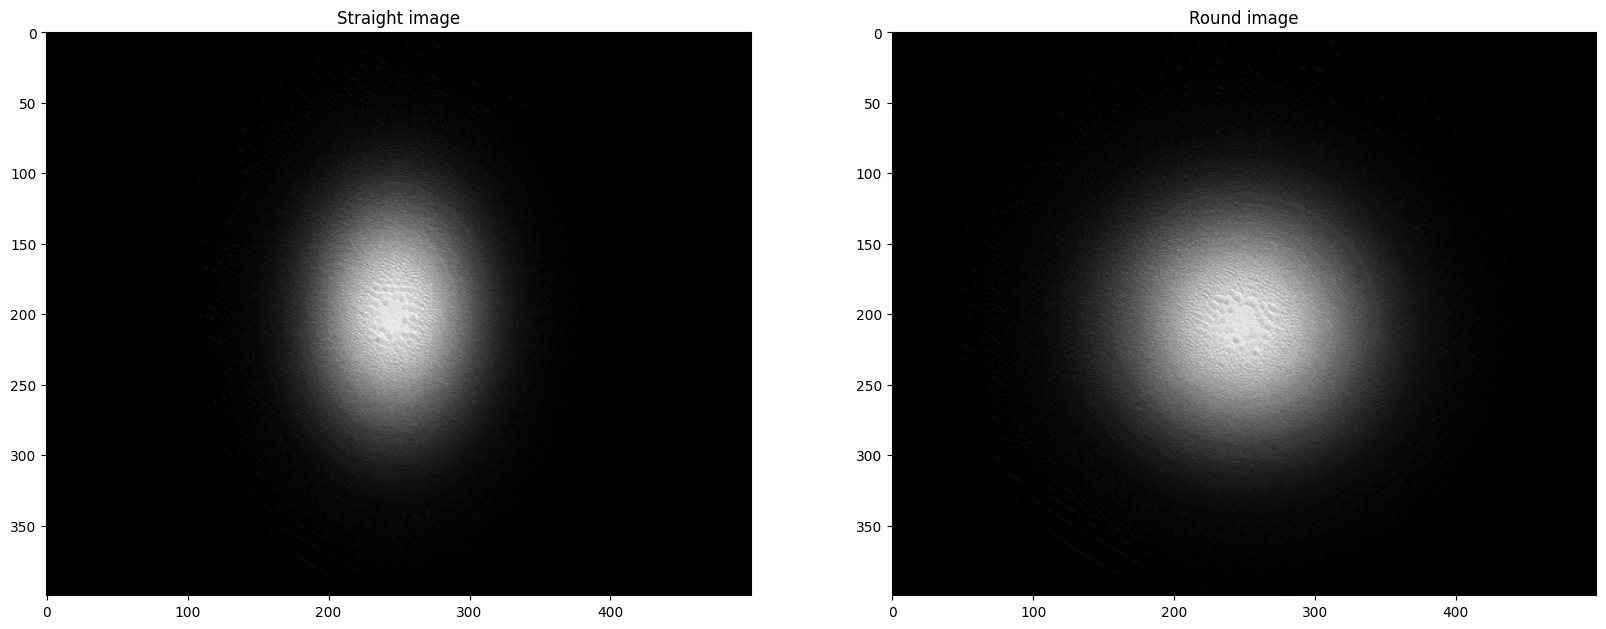

In [ ]:
# Plot the images side to side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(straight_image_cropped, cmap='gray')
ax[0].set_title('Straight image')

ax[1].imshow(round_image_cropped, cmap='gray')
ax[1].set_title('Round image')

In [1141]:
# Fit the images

def fit_image_final(image_cropped, fit_function, initial_guess):

    # Define the error function
    def error_function(arg):
        Z_fit = fit_function(image_cropped, arg)
        return np.sum((image_cropped - Z_fit)**2)

    # Perform the fit
    result = minimize(error_function, initial_guess, method='Nelder-Mead')

    # Return the result
    return result

In [1168]:
def normalised_Gaussian_fit(image, arg):
    sigmaX, alpha, beta, gamma, x_0, y_0, sigmaY = arg[0], arg[1], arg[2], arg[3], arg[4], arg[5], arg[6] # sigma, alpha, beta, gamma, x_0, y_0

    N_guess = image.shape[0]
    M_guess = image.shape[1]

    x = np.linspace(0, M_guess, M_guess)
    y = np.linspace(0, N_guess, N_guess)

    X, Y = np.meshgrid(x, y)
    X_new = X  * np.cos(np.radians(beta)) + Y * np.sin(np.radians(beta))
    Y_new =  -X * np.sin(np.radians(alpha)) + Y * np.cos(np.radians(alpha))

    Z = gamma*np.exp(-(((X_new - x_0*np.ones_like(X_new))**2) / (2.0 * (sigmaX)**2))) * np.exp(-(((Y_new - y_0*np.ones_like(Y_new))**2) / (2.0 * sigmaY**2)))
    return Z

In [1169]:
# Define round classic gaussian
def normalised_Gaussian_fit_sym(image, arg):
    sigma, gamma, x_0, y_0 = arg[0], arg[1], arg[2], arg[3]

    Z = np.zeros_like(image)
    x = np.linspace(0, image.shape[1], image.shape[1])
    y = np.linspace(0, image.shape[0], image.shape[0])
    X, Y = np.meshgrid(x, y)

    Z = gamma*np.exp(-((X - x_0)**2) / (2.0 * sigma**2)) * np.exp(-(((Y-y_0)**2) / (2.0 * sigma**2)))
    return Z

In [1170]:
fit_params_straight = fit_image_final(straight_image_cropped, normalised_Gaussian_fit, [100, 0, 0, 1, 250, 250, 100])
fit_params_round = fit_image_final(round_image_cropped, normalised_Gaussian_fit_sym, [100, 1, 250, 250])
print(fit_params_straight.x)
print(fit_params_round.x)

[ 3.93931797e+01 -2.44886781e-01 -4.22819534e-01  1.07771477e+02
  2.45829968e+02  2.01342473e+02  5.41713079e+01]
[ 55.87590855 154.19273147 248.87218572 207.59957192]


In [1171]:
# Compute residuals and standard deviation error for each fit
residual_straight = straight_image_cropped - normalised_Gaussian_fit(straight_image_cropped, fit_params_straight.x)
residual_round = round_image_cropped - normalised_Gaussian_fit_sym(round_image_cropped, fit_params_round.x)

relative_error_straight = np.std(residual_straight) / np.mean(straight_image_cropped)
relative_error_round = np.std(residual_round) / np.mean(round_image_cropped)


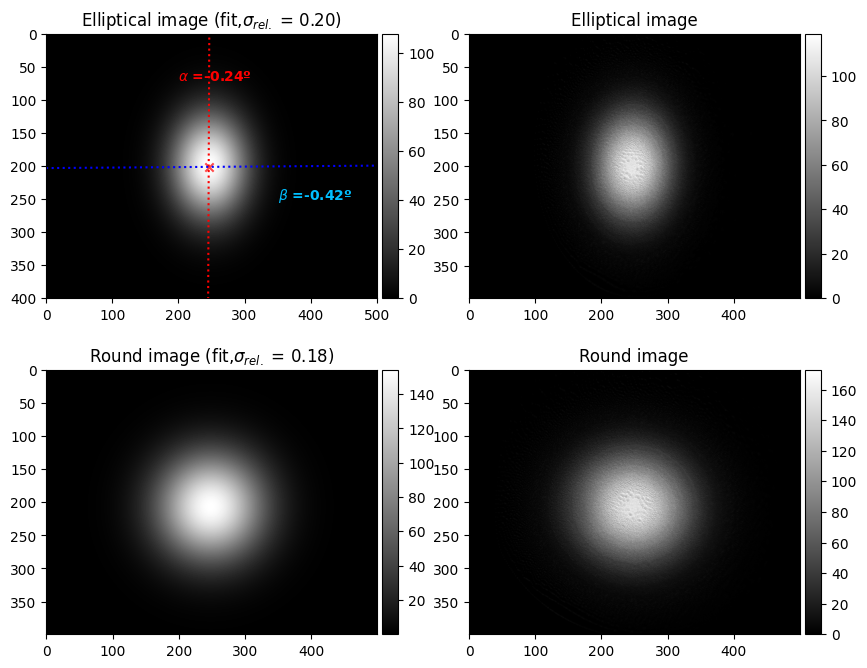

In [1176]:
# Plot the images side to side
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].imshow(normalised_Gaussian_fit(straight_image_cropped, fit_params_straight.x), cmap='gray')
ax[0, 0].set_title('Elliptical image (fit,' r'$\sigma_{rel.}$ = '+f'{relative_error_straight:.2f})')

# Draw the two lines red and blue with tangent of alpha and beta
x = np.linspace(0, straight_image_cropped.shape[1], 100)
ax[0, 0].plot(x, (x-fit_params_straight.x[4])* np.tan(np.radians(90-fit_params_straight.x[1])) + fit_params_straight.x[5], 'r:')
ax[0, 0].plot(x, (x-fit_params_straight.x[4]) * np.tan(np.radians(fit_params_straight.x[2])) + fit_params_straight.x[5], 'b:')
ax[0, 0].set_xlim(0, straight_image_cropped.shape[1])
ax[0, 0].set_ylim(straight_image_cropped.shape[0], 0)
ax[0,0].scatter(fit_params_straight.x[4], fit_params_straight.x[5], marker='x', color='r', alpha=0.7)
ax[0,0].text(200, 70, r'$\alpha$ ='+ f'{fit_params_straight.x[1]:.2f}º', color='r', fontweight='bold')
ax[0,0].text(350, 250, r'$\beta$ ='+ f'{fit_params_straight.x[2]:.2f}º', color='deepskyblue', fontweight='bold')

ax[1, 0].imshow(normalised_Gaussian_fit_sym(round_image_cropped, fit_params_round.x), cmap='gray')
ax[1, 0].set_title('Round image (fit,' r'$\sigma_{rel.}$ = '+f'{relative_error_round:.2f})')

ax[0,1].imshow(straight_image_cropped, cmap='gray')
ax[0,1].set_title('Elliptical image')

ax[1,1].imshow(round_image_cropped, cmap='gray')
ax[1,1].set_title('Round image')

# Add colorbars to each plot
divider0 = make_axes_locatable(ax[0, 0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[0, 0].images[0], cax=cax0)

divider1 = make_axes_locatable(ax[1, 0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[1, 0].images[0], cax=cax1)

divider2 = make_axes_locatable(ax[0, 1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[0, 1].images[0], cax=cax2)

divider3 = make_axes_locatable(ax[1, 1])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ax[1, 1].images[0], cax=cax3)